In [1]:
import sys
sys.path.append('../../NLP_analysis/')

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [147]:
dataset = pd.read_csv('../data/complete_cleaned_spellings_Restaurant_reviews.csv', index_col=0)
labels = dataset['Rating'] - 1

In [148]:
dataset= dataset[['Review', 'Rating', 'cleaned_text']]

In [149]:
# Define hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 64

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['cleaned_text'])
sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

In [5]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 685605 (2.62 MB)
Trainable params: 685605 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=5, batch_size=32)

Epoch 1/5
245/245 [==============================] - 13s 47ms/step - loss: 1.4668 - accuracy: 0.3900 - val_loss: 1.4669 - val_accuracy: 0.3871
Epoch 2/5
245/245 [==============================] - 11s 46ms/step - loss: 1.4469 - accuracy: 0.3975 - val_loss: 1.4498 - val_accuracy: 0.3871
Epoch 3/5
245/245 [==============================] - 11s 46ms/step - loss: 1.4377 - accuracy: 0.3905 - val_loss: 1.4522 - val_accuracy: 0.3871
Epoch 4/5
245/245 [==============================] - 11s 45ms/step - loss: 1.4362 - accuracy: 0.3898 - val_loss: 1.4541 - val_accuracy: 0.3871
Epoch 5/5
245/245 [==============================] - 11s 46ms/step - loss: 1.4400 - accuracy: 0.3896 - val_loss: 1.4535 - val_accuracy: 0.3871


In [7]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 1s 9ms/step - loss: 1.4535 - accuracy: 0.3871
Validation Loss: 1.4535293579101562
Validation Accuracy: 0.3871297240257263
62/62 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       356
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00       238
           3       0.00      0.00      0.00       465
           4       0.39      1.00      0.56       758

    accuracy                           0.39      1958
   macro avg       0.08      0.20      0.11      1958
weighted avg       0.15      0.39      0.22      1958



/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Observation
The model cannot detect 0 and 1 and 2 and 3. That's not convincing for the first model, but it's just a start(the main reason is the difference in the amount of data, with the fifth category being particularly large).

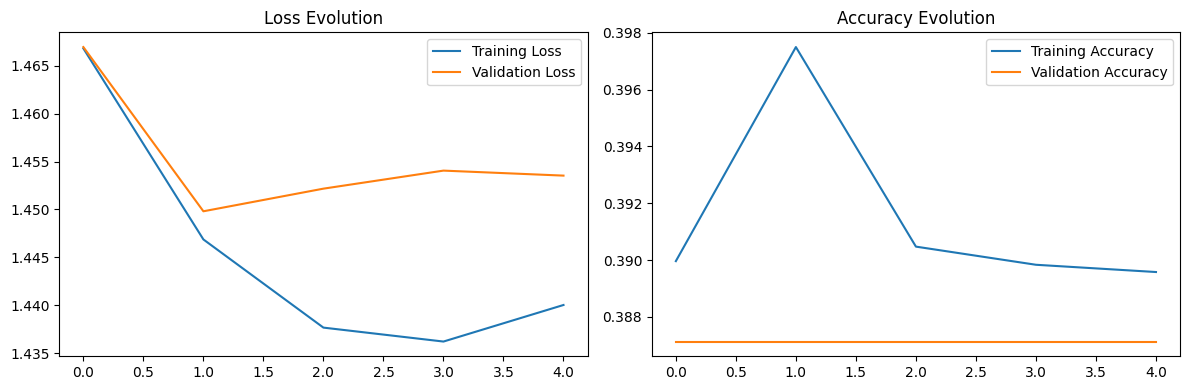

In [8]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
It's bad. But the general trend is almost same. By looking at these curves, I thought I could add epoch and callback first to see what was going on

## Add more epoch ，implementing a checkpoint to remember the best epoch, and implementing early stopping and LR to avoid overfitting*

In [9]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
checkpoint = ModelCheckpoint('model1.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_cb = ReduceLROnPlateau(monitor="loss", patience=10)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/20
245/245 [==============================] - ETA: 0s - loss: 1.4378 - accuracy: 0.3900
Epoch 1: val_loss improved from inf to 1.45518, saving model to model1.h5
245/245 [==============================] - 11s 46ms/step - loss: 1.4378 - accuracy: 0.3900 - val_loss: 1.4552 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 2/20
  3/245 [..............................] - ETA: 10s - loss: 1.4793 - accuracy: 0.3333

/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - ETA: 0s - loss: 1.4369 - accuracy: 0.3898
Epoch 2: val_loss improved from 1.45518 to 1.45336, saving model to model1.h5
245/245 [==============================] - 11s 45ms/step - loss: 1.4369 - accuracy: 0.3898 - val_loss: 1.4534 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 3/20
245/245 [==============================] - ETA: 0s - loss: 1.4385 - accuracy: 0.3906
Epoch 3: val_loss improved from 1.45336 to 1.45246, saving model to model1.h5
245/245 [==============================] - 11s 46ms/step - loss: 1.4385 - accuracy: 0.3906 - val_loss: 1.4525 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 4/20
245/245 [==============================] - ETA: 0s - loss: 1.4382 - accuracy: 0.3898
Epoch 4: val_loss improved from 1.45246 to 1.45076, saving model to model1.h5
245/245 [==============================] - 11s 46ms/step - loss: 1.4382 - accuracy: 0.3898 - val_loss: 1.4508 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 5/20
245/245 [==============================]

In [10]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 1s 10ms/step - loss: 1.0803 - accuracy: 0.5700
Validation Loss: 1.0803183317184448
Validation Accuracy: 0.5699693560600281
62/62 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.60      0.82      0.69       356
           1       0.00      0.00      0.00       141
           2       0.29      0.16      0.20       238
           3       0.40      0.35      0.38       465
           4       0.66      0.82      0.73       758

    accuracy                           0.57      1958
   macro avg       0.39      0.43      0.40      1958
weighted avg       0.50      0.57      0.52      1958



/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


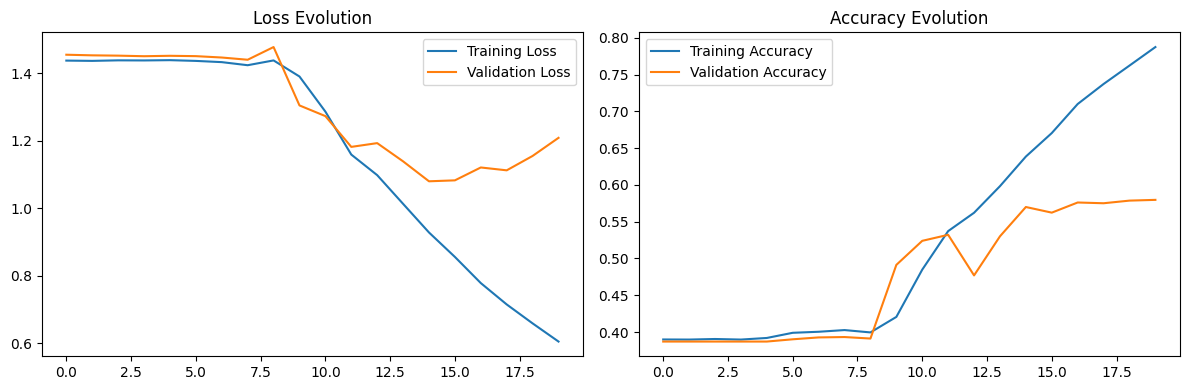

In [11]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
This model is a great improvement over the previous one. But we still face the same problem with class 2. By looking at the curve, we see that overfitting is still important. I'm going to add class weights

## Class_Weights

In [26]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [27]:
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/20
244/245 [============================>.] - ETA: 0s - loss: 0.7211 - accuracy: 0.7729
Epoch 1: val_loss did not improve from 1.08032
245/245 [==============================] - 12s 48ms/step - loss: 0.7208 - accuracy: 0.7730 - val_loss: 1.2689 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 2/20
245/245 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.7878
Epoch 2: val_loss did not improve from 1.08032
245/245 [==============================] - 11s 47ms/step - loss: 0.6848 - accuracy: 0.7878 - val_loss: 1.3306 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 3/20
244/245 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.8081
Epoch 3: val_loss did not improve from 1.08032
245/245 [==============================] - 11s 47ms/step - loss: 0.6516 - accuracy: 0.8079 - val_loss: 1.3372 - val_accuracy: 0.5184 - lr: 0.0010
Epoch 4/20
245/245 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.8200
Epoch 4: val_loss did not improve fro

In [28]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 1s 10ms/step - loss: 1.2689 - accuracy: 0.5352
Validation Loss: 1.2688566446304321
Validation Accuracy: 0.5352400541305542
62/62 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       356
           1       0.21      0.37      0.27       141
           2       0.25      0.34      0.29       238
           3       0.41      0.31      0.35       465
           4       0.73      0.73      0.73       758

    accuracy                           0.54      1958
   macro avg       0.48      0.47      0.46      1958
weighted avg       0.57      0.54      0.54      1958



### Obeservation
After adding class weights, it is clear that the improvement in the second category is very large

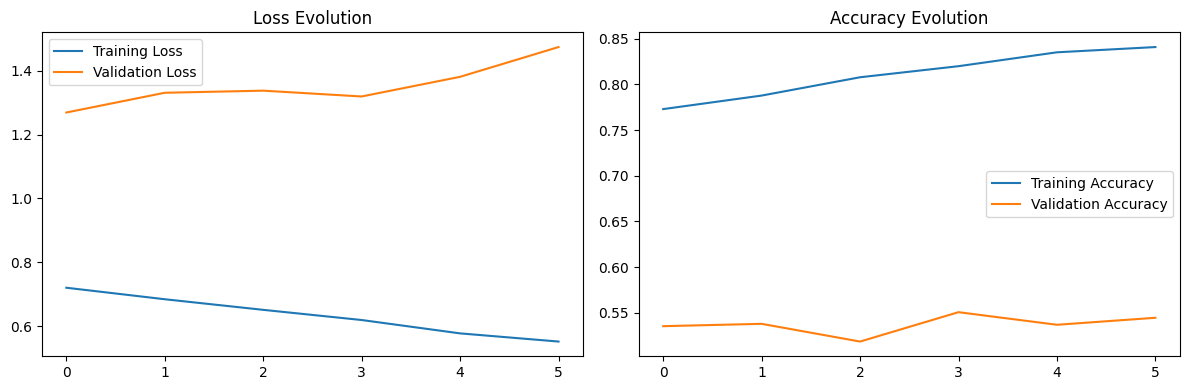

In [29]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
Although the numbers look more reasonable, the graph shows that the model is still overfitting.

## Try reduce the complexity of the model to reduce overfitting

In [30]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 673349 (2.57 MB)
Trainable params: 673349 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I will continue to retain class weights for all new models

In [35]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/10
245/245 [==============================] - ETA: 0s - loss: 1.5254 - accuracy: 0.3657
Epoch 1: val_loss did not improve from 1.08032
245/245 [==============================] - 8s 32ms/step - loss: 1.5254 - accuracy: 0.3657 - val_loss: 1.5102 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 2/10
245/245 [==============================] - ETA: 0s - loss: 1.4058 - accuracy: 0.4494
Epoch 2: val_loss did not improve from 1.08032
245/245 [==============================] - 7s 29ms/step - loss: 1.4058 - accuracy: 0.4494 - val_loss: 1.4377 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 3/10
244/245 [============================>.] - ETA: 0s - loss: 1.2861 - accuracy: 0.4773
Epoch 3: val_loss did not improve from 1.08032
245/245 [==============================] - 7s 29ms/step - loss: 1.2849 - accuracy: 0.4780 - val_loss: 1.2926 - val_accuracy: 0.4203 - lr: 0.0010
Epoch 4/10
244/245 [============================>.] - ETA: 0s - loss: 1.1869 - accuracy: 0.5113
Epoch 4: val_loss did not improve from 1

In [36]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

 1/62 [..............................] - ETA: 1s - loss: 1.2002 - accuracy: 0.5000

62/62 [==============================] - 0s 6ms/step - loss: 1.2699 - accuracy: 0.4259
Validation Loss: 1.2698837518692017
Validation Accuracy: 0.42594483494758606
62/62 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.48      0.13      0.21       356
           1       0.16      0.36      0.22       141
           2       0.21      0.33      0.25       238
           3       0.39      0.10      0.16       465
           4       0.58      0.81      0.68       758

    accuracy                           0.43      1958
   macro avg       0.36      0.35      0.30      1958
weighted avg       0.44      0.43      0.39      1958



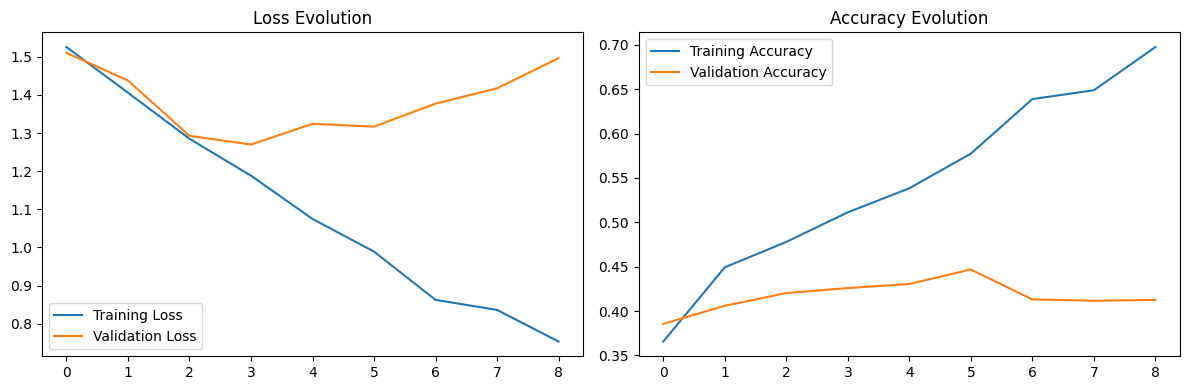

In [37]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation

This simple model also suffers from overfitting.

## Try to change the model layers

In [42]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           41088     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/10
239/245 [============================>.] - ETA: 0s - loss: 1.4174 - accuracy: 0.4423
Epoch 1: val_loss did not improve from 1.08032
245/245 [==============================] - 2s 9ms/step - loss: 1.4123 - accuracy: 0.4450 - val_loss: 1.0895 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 2/10
240/245 [============================>.] - ETA: 0s - loss: 1.0067 - accuracy: 0.6344
Epoch 2: val_loss improved from 1.08032 to 0.97772, saving model to model1.h5
245/245 [==============================] - 2s 8ms/step - loss: 1.0067 - accuracy: 0.6348 - val_loss: 0.9777 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 3/10
 20/245 [=>............................] - ETA: 1s - loss: 0.7912 - accuracy: 0.7688

/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/245 [============================>.] - ETA: 0s - loss: 0.7794 - accuracy: 0.7394
Epoch 3: val_loss did not improve from 0.97772
245/245 [==============================] - 2s 9ms/step - loss: 0.7806 - accuracy: 0.7383 - val_loss: 0.9916 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 4/10
243/245 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.8219
Epoch 4: val_loss did not improve from 0.97772
245/245 [==============================] - 2s 9ms/step - loss: 0.5705 - accuracy: 0.8214 - val_loss: 1.0588 - val_accuracy: 0.6032 - lr: 0.0010
Epoch 5/10
241/245 [============================>.] - ETA: 0s - loss: 0.3877 - accuracy: 0.8902
Epoch 5: val_loss did not improve from 0.97772
245/245 [==============================] - 2s 9ms/step - loss: 0.3879 - accuracy: 0.8902 - val_loss: 1.1223 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 6/10
241/245 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.9306
Epoch 6: val_loss did not improve from 0.97772
245/245

In [44]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 0s 3ms/step - loss: 0.9777 - accuracy: 0.6052
Validation Loss: 0.977722704410553
Validation Accuracy: 0.6052094101905823
62/62 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       356
           1       0.35      0.32      0.33       141
           2       0.35      0.42      0.38       238
           3       0.49      0.49      0.49       465
           4       0.77      0.70      0.73       758

    accuracy                           0.61      1958
   macro avg       0.54      0.54      0.54      1958
weighted avg       0.61      0.61      0.61      1958



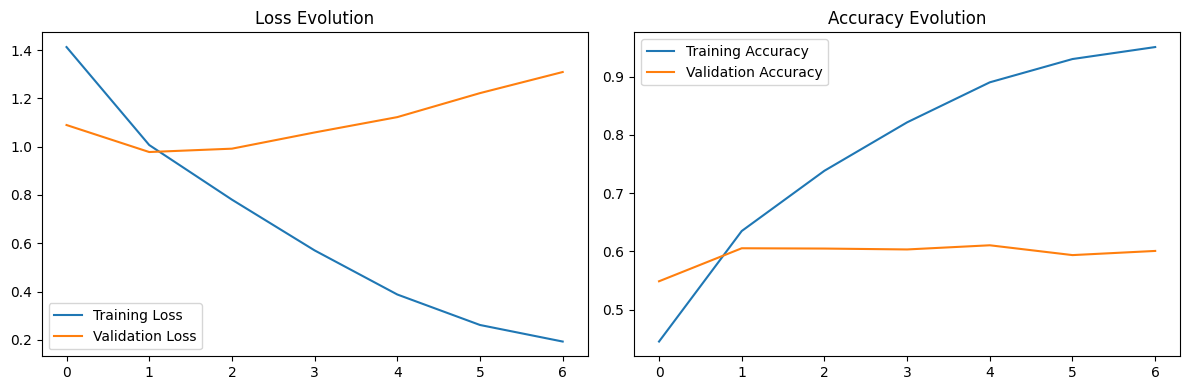

In [45]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
This is one of the ways to improve the results, the model is under overfitting, but the accuracy is improved, and knowing the difficulties we face, the recall rate of Class 2 is average. We will continue to experiment with other models

## Another different model

In [150]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),  # Couche de convolution avec régularisation L2
    GlobalMaxPooling1D(),  # Pooling global
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01))  # Couche Dense avec régularisation L2
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 64)           640000    
                                                                 
 conv1d_13 (Conv1D)          (None, 96, 128)           41088     
                                                                 
 global_max_pooling1d_13 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_21 (Dense)            (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/10
242/245 [============================>.] - ETA: 0s - loss: 1.6853 - accuracy: 0.3502
Epoch 1: val_loss did not improve from 0.45455
245/245 [==============================] - 2s 9ms/step - loss: 1.6848 - accuracy: 0.3507 - val_loss: 1.4031 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 2/10
238/245 [============================>.] - ETA: 0s - loss: 1.3619 - accuracy: 0.5453
Epoch 2: val_loss did not improve from 0.45455
245/245 [==============================] - 2s 8ms/step - loss: 1.3638 - accuracy: 0.5436 - val_loss: 1.2682 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 3/10
244/245 [============================>.] - ETA: 0s - loss: 1.2737 - accuracy: 0.5751
Epoch 3: val_loss did not improve from 0.45455
245/245 [==============================] - 2s 8ms/step - loss: 1.2734 - accuracy: 0.5752 - val_loss: 1.2994 - val_accuracy: 0.5215 - lr: 0.0010
Epoch 4/10
241/245 [============================>.] - ETA: 0s - loss: 1.2151 - accuracy: 0.6188
Epoch 4: val_loss did not improve from 0.45

In [152]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 0s 2ms/step - loss: 1.2252 - accuracy: 0.5516
Validation Loss: 1.2252089977264404
Validation Accuracy: 0.5515832304954529
62/62 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       356
           1       0.23      0.32      0.27       141
           2       0.29      0.33      0.31       238
           3       0.46      0.52      0.49       465
           4       0.73      0.68      0.70       758

    accuracy                           0.55      1958
   macro avg       0.50      0.48      0.48      1958
weighted avg       0.58      0.55      0.56      1958



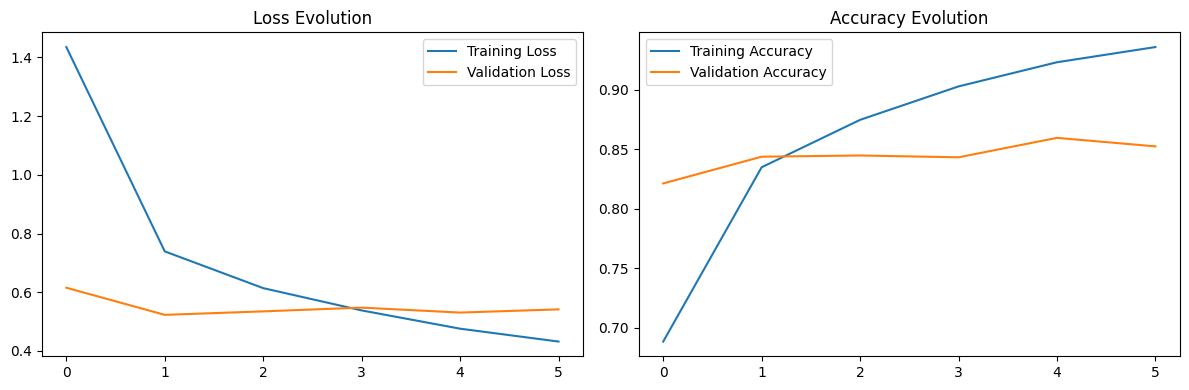

In [146]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
Although the accuracy of this model is lower than that of the previous model, the curve shows a smaller training and validation loss gap, which indicates that the model has better generalization ability and similar training and validation performance. This is most likely our best model, but I will continue to try other models

## Another different model

In [96]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),  # Bi-LSTM
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 64)           640000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=5, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/5
245/245 [==============================] - ETA: 0s - loss: 1.3459 - accuracy: 0.4722
Epoch 1: val_loss did not improve from 0.96678
245/245 [==============================] - 9s 31ms/step - loss: 1.3459 - accuracy: 0.4722 - val_loss: 1.0527 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 2/5
243/245 [============================>.] - ETA: 0s - loss: 0.9812 - accuracy: 0.6434
Epoch 2: val_loss did not improve from 0.96678
245/245 [==============================] - 7s 29ms/step - loss: 0.9809 - accuracy: 0.6432 - val_loss: 1.0057 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 3/5
245/245 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.7075
Epoch 3: val_loss did not improve from 0.96678
245/245 [==============================] - 7s 30ms/step - loss: 0.8243 - accuracy: 0.7075 - val_loss: 1.1322 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 4/5
245/245 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.7622
Epoch 4: val_loss did not improve from 0.966

In [98]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

 1/62 [..............................] - ETA: 1s - loss: 1.3544 - accuracy: 0.5938

62/62 [==============================] - 0s 7ms/step - loss: 1.2705 - accuracy: 0.5700
Validation Loss: 1.2704910039901733
Validation Accuracy: 0.5699693560600281
62/62 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       356
           1       0.26      0.48      0.33       141
           2       0.33      0.47      0.39       238
           3       0.50      0.37      0.42       465
           4       0.75      0.73      0.74       758

    accuracy                           0.57      1958
   macro avg       0.52      0.53      0.51      1958
weighted avg       0.61      0.57      0.58      1958



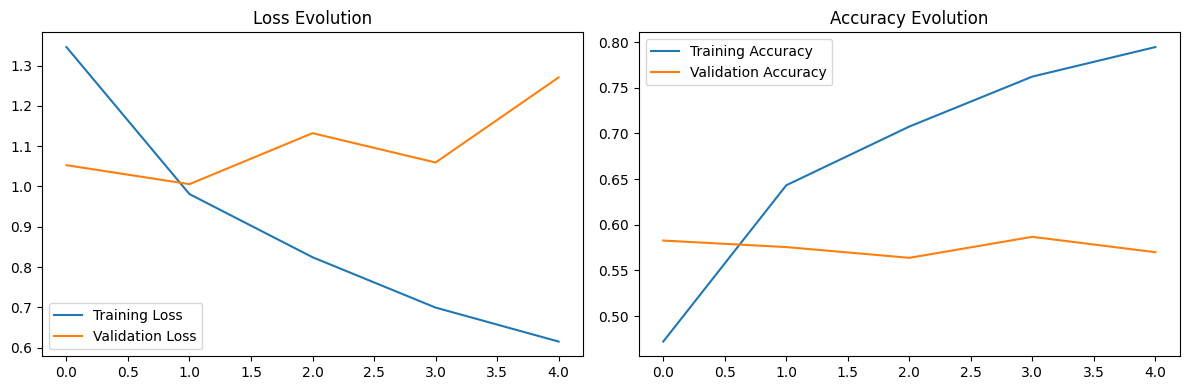

In [99]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Obsevation
I can see that the accuracy of this model is also better than the accuracy of the original model, but it has a better recall rate for class 2, but the curve also fully shows that this model has serious overfitting, and I will continue to try other models

## Another different model

In [191]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),  # Bi-LSTM with L2 regularization
    Dropout(0.5),  # Increased dropout rate
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))  # Regularized Dense layer
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 64)           640000    
                                                                 
 bidirectional_8 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/10
244/245 [============================>.] - ETA: 0s - loss: 2.1769 - accuracy: 0.2869
Epoch 1: val_loss did not improve from 0.45455
245/245 [==============================] - 8s 30ms/step - loss: 2.1745 - accuracy: 0.2869 - val_loss: 1.5130 - val_accuracy: 0.3488 - lr: 0.0010
Epoch 2/10
244/245 [============================>.] - ETA: 0s - loss: 1.3521 - accuracy: 0.4475
Epoch 2: val_loss did not improve from 0.45455
245/245 [==============================] - 7s 28ms/step - loss: 1.3520 - accuracy: 0.4474 - val_loss: 1.2420 - val_accuracy: 0.4765 - lr: 0.0010
Epoch 3/10
245/245 [==============================] - ETA: 0s - loss: 1.2455 - accuracy: 0.4835
Epoch 3: val_loss did not improve from 0.45455
245/245 [==============================] - 7s 29ms/step - loss: 1.2455 - accuracy: 0.4835 - val_loss: 1.2421 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 4/10
243/245 [============================>.] - ETA: 0s - loss: 1.2137 - accuracy: 0.4994
Epoch 4: val_loss did not improve from 0

In [193]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 0s 7ms/step - loss: 1.2392 - accuracy: 0.4939
Validation Loss: 1.2392081022262573
Validation Accuracy: 0.4938713014125824
62/62 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.75      0.65      0.69       356
           1       0.26      0.33      0.29       141
           2       0.21      0.34      0.26       238
           3       0.43      0.50      0.46       465
           4       0.70      0.50      0.58       758

    accuracy                           0.49      1958
   macro avg       0.47      0.46      0.46      1958
weighted avg       0.55      0.49      0.51      1958



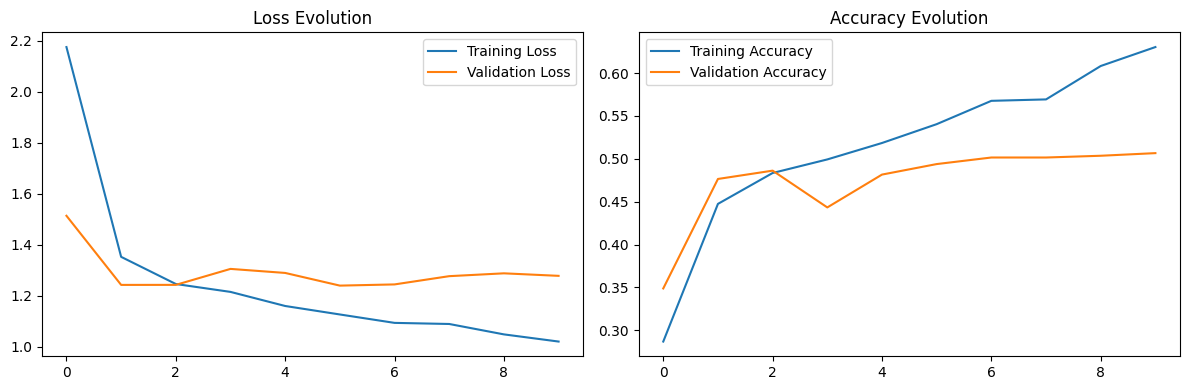

In [194]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation
The curve of this model is also good, but the precision of the model is lower, and the precision of classes 2, 3 and 4 is worse. Although I tried to adjust the parameters for many times, I still couldn't get the desired result.

## Best model

After considering several models together, I believe that my following model (my second additional different model) is my best model. Although its accuracy (0.55) is not as good as that of the first additional model (0.6), its curve fit is better, indicating better generalization and higher confidence. The last model had a better curve, but its accuracy was low (0.49), so I didn't end up choosing it as my best model

In [134]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),  # Couche de convolution avec régularisation L2
    GlobalMaxPooling1D(),  # Pooling global
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01))  # Couche Dense avec régularisation L2
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 64)           640000    
                                                                 


 conv1d_10 (Conv1D)          (None, 96, 128)           41088     
                                                                 
 global_max_pooling1d_10 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_18 (Dense)            (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/20
240/245 [============================>.] - ETA: 0s - loss: 1.7043 - accuracy: 0.3210
Epoch 1: val_loss did not improve from 0.96678
245/245 [==============================] - 2s 9ms/step - loss: 1.6998 - accuracy: 0.3239 - val_loss: 1.4208 - val_accuracy: 0.4285 - lr: 0.0010
Epoch 2/20
242/245 [============================>.] - ETA: 0s - loss: 1.3775 - accuracy: 0.5329
Epoch 2: val_loss did not improve from 0.96678
245/245 [==============================] - 2s 10ms/step - loss: 1.3746 - accuracy: 0.5333 - val_loss: 1.2780 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 3/20
243/245 [============================>.] - ETA: 0s - loss: 1.2791 - accuracy: 0.5823
Epoch 3: val_loss did not improve from 0.96678
245/245 [==============================] - 2s 9ms/step - loss: 1.2782 - accuracy: 0.5833 - val_loss: 1.2136 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 4/20
243/245 [============================>.] - ETA: 0s - loss: 1.2198 - accuracy: 0.6092
Epoch 4: val_loss did not improve from 0.9

In [136]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 0s 2ms/step - loss: 1.2086 - accuracy: 0.5501
Validation Loss: 1.208594799041748
Validation Accuracy: 0.5500510931015015
62/62 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.63      0.70       356
           1       0.24      0.42      0.30       141
           2       0.33      0.21      0.26       238
           3       0.43      0.49      0.46       465
           4       0.70      0.68      0.69       758

    accuracy                           0.55      1958
   macro avg       0.49      0.49      0.48      1958
weighted avg       0.57      0.55      0.56      1958



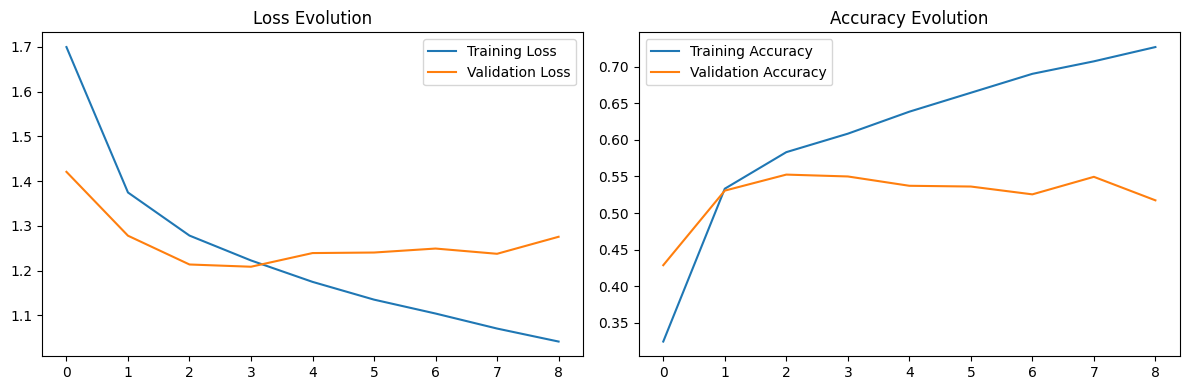

In [137]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### Observation

The results are mediocre, but we have a model with less overfitting. These curves are close to each other, so we can imagine that this model will generalize better

## Re mapping

In fact, the accuracy of my data is mostly due to the fact that the data sample is too low. If I Re map the data, 123 as 1 means negatif and 45 as positive. Classes are balanced by remapping and multiple classes or numerical ranges are mapped to fewer classes to reduce the complexity of model training or analysis. The accuracy of my best models will be greatly improved

In [138]:
dataset = pd.read_csv('../data/complete_cleaned_spellings_Restaurant_reviews.csv', index_col=0)
dataset= dataset[['Review', 'Rating', 'cleaned_text']]
mapping = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}
dataset['Rating'] = dataset['Rating'].map(mapping)
labels = dataset['Rating'].values

In [139]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),  # Couche de convolution avec régularisation L2
    GlobalMaxPooling1D(),  # Pooling global
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01))  # Couche Dense avec régularisation L2
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 64)           640000    
                                                                 
 conv1d_11 (Conv1D)          (None, 96, 128)           41088     
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
checkpoint = ModelCheckpoint('model1.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_cb = ReduceLROnPlateau(monitor="loss", patience=10)


history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=12, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/12
242/245 [============================>.] - ETA: 0s - loss: 0.9035 - accuracy: 0.7066
Epoch 1: val_loss improved from inf to 0.54773, saving model to model1.h5
245/245 [==============================] - 2s 9ms/step - loss: 0.9001 - accuracy: 0.7078 - val_loss: 0.5477 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 2/12
 20/245 [=>............................] - ETA: 1s - loss: 0.5180 - accuracy: 0.8609

/Users/kzd/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/245 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8593
Epoch 2: val_loss improved from 0.54773 to 0.47070, saving model to model1.h5
245/245 [==============================] - 2s 9ms/step - loss: 0.4779 - accuracy: 0.8595 - val_loss: 0.4707 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 3/12
244/245 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.8890
Epoch 3: val_loss improved from 0.47070 to 0.45455, saving model to model1.h5
245/245 [==============================] - 2s 9ms/step - loss: 0.4083 - accuracy: 0.8893 - val_loss: 0.4546 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 4/12
239/245 [============================>.] - ETA: 0s - loss: 0.3641 - accuracy: 0.9068
Epoch 4: val_loss did not improve from 0.45455
245/245 [==============================] - 2s 9ms/step - loss: 0.3650 - accuracy: 0.9062 - val_loss: 0.4611 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 5/12
241/245 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy:

In [141]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

62/62 [==============================] - 0s 3ms/step - loss: 0.4546 - accuracy: 0.8647
Validation Loss: 0.45455214381217957
Validation Accuracy: 0.8646578192710876
62/62 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       735
           1       0.86      0.94      0.90      1223

    accuracy                           0.86      1958
   macro avg       0.87      0.84      0.85      1958
weighted avg       0.87      0.86      0.86      1958



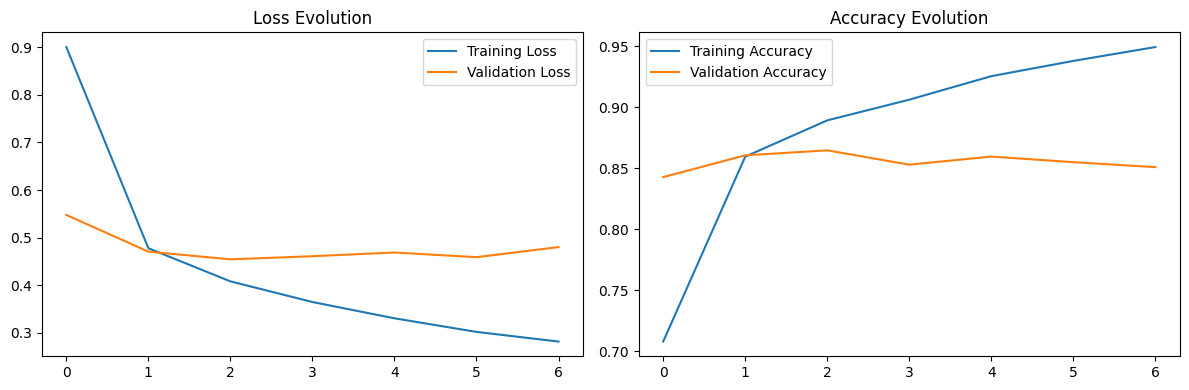

In [142]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

## Conclusion

Finally, after remapping, we can see that the accuracy of this model has greatly improved. In fact, my data set itself is trying two kinds, trying to classify rating or trying to classify only positive and negative. Facts have proved that the amount of data in this data set is still too small and unbalanced for classification rating